In [1]:
import torch

In [2]:
model = torch.load('uncertain_semantic_.pt')

FileNotFoundError: [Errno 2] No such file or directory: 'semantic_resnet_34.pt'

In [3]:
model

FPN(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_

In [6]:
import h5py
import numpy as np
import json
import os
import cv2
from pytransform3d.transform_manager import TransformManager
import matplotlib.pyplot as plt
import kornia
import skimage

In [7]:
files_directory = '../learning_blenerproc/images_pose_robocup/'
filenames = [f for f in sorted(os.listdir(files_directory)) if os.path.isfile(os.path.join(files_directory, f))]


## Saving this for tracking the mistakes made

In [17]:
def give_rotation_translation(old_pose, new_pose):
    tm = TransformManager()
    tm.add_transform("world", "old_pose", old_pose)
    tm.add_transform("world", "new_pose", new_pose)
    new2old = tm.get_transform("old_pose", "new_pose")
    return new2old

def calculate_homography_matrix(cam_matrix, old_pose, new_pose, old_seg):
    height = cam_matrix[5]
    width = cam_matrix[2]
    f = cam_matrix[0]
    K = np.array(cam_matrix).reshape(3,3)
    K = np.hstack((K, [[0.],[0.],[0.]]))
    Kinv= np.matrix([[1, 0, -width],
                [0, 1, -height],
                [0, 0, f  ],
                [0, 0, 1   ]])
    T = give_rotation_translation(old_pose, new_pose)
    print ('#####',T[2,3])
    #T[:3, 3] = T[:3, 3] * 100
    print (" T with previous frame: ", T[:3,3])
    #T[:3, 3] = 0.0
    
    #T = np.matrix([[1, 0, 0, 0],
    #               [0, 1, 0, 0],
    #               [0, 0, 1, 0],
    #               [0, 0, 0, 1]])
    #print (K, Kinv)
    # Final and overall transformation matrix
    print ('######### K')
    print (K)
    print ('######### T')
    print (T)
    print ('######### Kinv')
    print (Kinv)
    
    H = K * (T * Kinv)
    print (H, H.shape)
    #Normalizing Homography matrix (Please find reference for this )
    H = H/H[2,2]
    print (H)
    
    return H

######  12.hdf5
image shape  (512, 512, 3)
mask shape  (512, 512)
 tensor image shape  torch.Size([3, 512, 512])
 tensor image shape  torch.Size([1, 3, 512, 512])
[711.1112738715278, 0.0, 255.5, 0.0, 711.1112738715278, 255.5, 0.0, 0.0, 1.0]
current T  [[-0.01508968]
 [-0.04995073]
 [ 0.94997483]]
######  13.hdf5
image shape  (512, 512, 3)
mask shape  (512, 512)
 tensor image shape  torch.Size([3, 512, 512])
 tensor image shape  torch.Size([1, 3, 512, 512])
[711.1112738715278, 0.0, 255.5, 0.0, 711.1112738715278, 255.5, 0.0, 0.0, 1.0]
current T  [[-0.01540309]
 [-0.04824003]
 [ 0.71599245]]
##### -0.2339823842048644
 T with previous frame:  [ -0.03134059   0.17107017 -23.39823842]
######### K
[[711.11127387   0.         255.5          0.        ]
 [  0.         711.11127387 255.5          0.        ]
 [  0.           0.           1.           0.        ]]
######### T
[[ 1.00000000e+00  4.98732999e-18  0.00000000e+00 -3.13405879e-02]
 [-1.33356867e-16  1.00000000e+00  0.00000000e+00  1.71

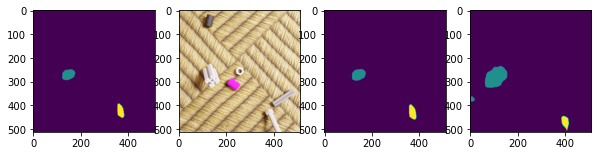

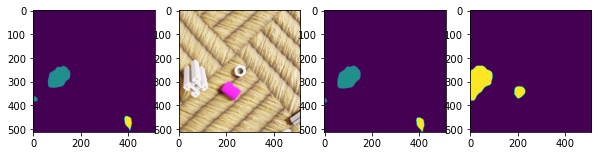

In [19]:
old_pose_flag = None
old_pose = None
old_alpha = None
for filename in filenames:
    file_path = os.path.join(files_directory, filename)

    with h5py.File(file_path, 'r') as data:
        print ("###### ", filename)
        image = np.array(data['colors'])
        print ("image shape ", image.shape)
        mask = np.array(data['class_segmaps'])
        print ("mask shape ", mask.shape)

        
        t_img = kornia.image_to_tensor(image)
        print (" tensor image shape ", t_img.shape)
        t_img = torch.unsqueeze(t_img.float(), dim=0)  # BxCxHxW
        print (" tensor image shape ", t_img.shape)
        
        with torch.no_grad():
            model.eval()
            logits = model(t_img)
            
        evidence  = torch.relu(logits)
        alpha = evidence + 1
        prob = alpha / torch.sum(alpha, dim=1, keepdim=True)
        
        transformation_matrix = json.loads(np.array(data['camera_pose']).item().decode()) 
        print (transformation_matrix['cam_K'])
        R = np.array(transformation_matrix['cam_R_w2c']).reshape(3,3)
        T = np.array(transformation_matrix['cam_t_w2c']).reshape(3,1)
        print ("current T ", T)
        H=np.hstack((R,T))
        H = np.vstack((H,[0., 0., 0., 1.]))
        
        if old_pose_flag:
          
            M = calculate_homography_matrix(transformation_matrix['cam_K'], old_pose, H, 
                                    old_image)
            t_M = torch.FloatTensor(M)
            t_M = torch.unsqueeze(t_M.float(), dim=0)  # BxCxHxW
            # warp the original image by the found transform
            wrap_alpha = kornia.geometry.warp_perspective(old_alpha, t_M, dsize=(512, 512))
            
            old_pred = old_alpha.argmax(dim=1, keepdim=True)
            wrap_pred = wrap_alpha.argmax(dim=1, keepdim=True)
            max_prob = alpha.argmax(dim=1, keepdim=True)
            

            
            # convert back to numpy
            #image_warp = kornia.tensor_to_image(img_warp.byte()[0])

            #plotting
            plt.figure(figsize=(10, 5))
            ax = plt.subplot(1, 4, 1)
            plt.imshow(old_pred.numpy().squeeze())
            ax = plt.subplot(1, 4, 2)
            plt.imshow(image)
            ax = plt.subplot(1, 4, 3)
            plt.imshow(wrap_pred.numpy().squeeze())
            ax = plt.subplot(1, 4, 4)
            plt.imshow(max_prob.numpy().squeeze())
            
            
            #####
            old_pose = H
            old_alpha = alpha
        else:
            old_pose_flag = True
            old_pose = H
            old_alpha = alpha
        

## Epipolar Equation 

date April 7th

In [8]:
def give_rotation_translation(old_pose, new_pose):
    tm = TransformManager()
    tm.add_transform("world", "old_pose", old_pose)
    tm.add_transform("world", "new_pose", new_pose)
    new2old = tm.get_transform("old_pose", "new_pose")
    return new2old

def transform_segmask(cam_matrix, old_pose, new_pose, old_seg, old_depth):
    height, width = old_depth.shape

    f = cam_matrix[0]
    K = np.array(cam_matrix).reshape(3,3)
    Kinv= np.linalg.inv(K)
    
    R_and_T = give_rotation_translation(old_pose, new_pose)

    R = R_and_T[:3,:3]
    T = R_and_T[:3,3].reshape(3,1)

    
    x = np.arange(height)
    y = np.arange(width)

    # full coorindate arrays
    xx, yy = np.meshgrid(x, y, indexing='ij')
    xx = xx.reshape(height*width)
    yy = yy.reshape(height*width)

    ## Stacking to make the matrix 3 x points
    pts = np.vstack((xx, yy, np.ones_like(xx)))
    
    ravelFilledDepth = old_depth.reshape(height*width)

    new_pt = K.dot(R).dot(Kinv).dot(pts) + K.dot(T/ravelFilledDepth)
    new_pt = new_pt / new_pt[2][:]
    new_pt = new_pt.round().astype(int)
    new_pt = new_pt.clip(min=0, max=511)
    
    dst = -1*np.zeros_like(old_seg)
    dst[new_pt[0], new_pt[1]] = old_seg[xx, yy ] 
    dst = skimage.measure.block_reduce(dst, (2,2), np.max)
    dst = skimage.transform.resize(dst, (height,width),
                       anti_aliasing=True)

    
    return dst

######  15.hdf5
image shape  (512, 512, 3)
mask shape  (512, 512)
depth  shape  (512, 512)
Keys: <KeysViewHDF5 ['blender_proc_version', 'camera_pose', 'class_segmaps', 'colors', 'depth']>
[711.1112738715278, 0.0, 255.5, 0.0, 711.1112738715278, 255.5, 0.0, 0.0, 1.0]
current T  [[0.09601871]
 [0.12744778]
 [0.68295449]]
######  16.hdf5
image shape  (512, 512, 3)
mask shape  (512, 512)
depth  shape  (512, 512)
Keys: <KeysViewHDF5 ['blender_proc_version', 'camera_pose', 'class_segmaps', 'colors', 'depth']>
[711.1112738715278, 0.0, 255.5, 0.0, 711.1112738715278, 255.5, 0.0, 0.0, 1.0]
current T  [[0.09783638]
 [0.12838067]
 [0.50469154]]
call
######  17.hdf5
image shape  (512, 512, 3)
mask shape  (512, 512)
depth  shape  (512, 512)
Keys: <KeysViewHDF5 ['blender_proc_version', 'camera_pose', 'class_segmaps', 'colors', 'depth']>
[711.1112738715278, 0.0, 255.5, 0.0, 711.1112738715278, 255.5, 0.0, 0.0, 1.0]
current T  [[0.09872852]
 [0.12762235]
 [0.32758072]]
call


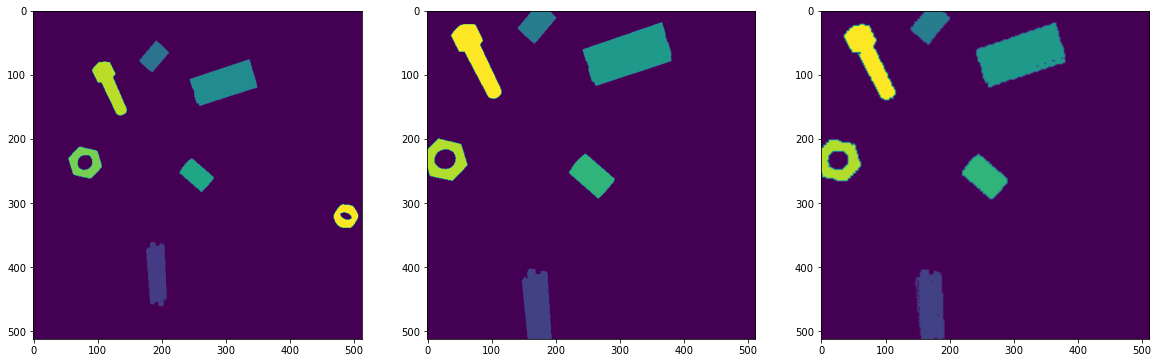

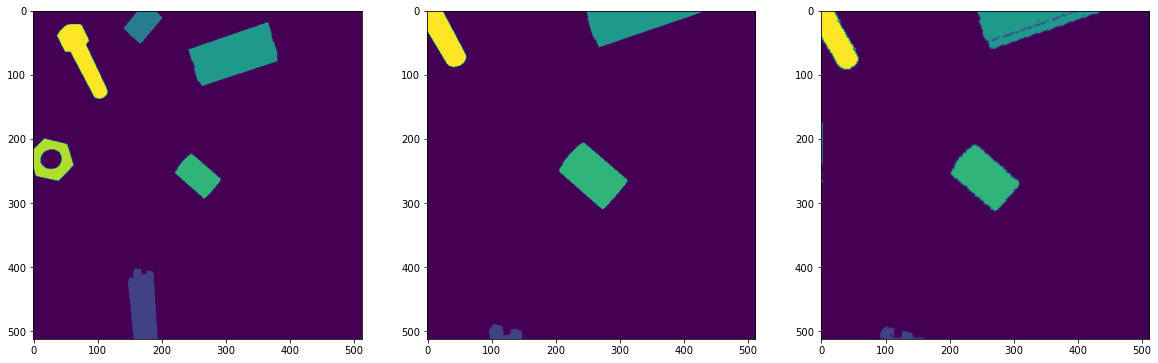

In [9]:
old_pose_flag = None
old_pose = None
old_image = None
old_depth = None
old_seg = None
for filename in filenames:
    file_path = os.path.join(files_directory, filename)

    with h5py.File(file_path, 'r') as data:
        print ("###### ", filename)
        image = np.array(data['colors'])
        print ("image shape ", image.shape)
        mask = np.array(data['class_segmaps'])
        print ("mask shape ", mask.shape)
        depth = np.array(data['depth'])
        print ("depth  shape ", depth.shape)

        # List all groups
        # List all groups
        print("Keys: %s" % data.keys())
        transformation_matrix = json.loads(np.array(data['camera_pose']).item().decode()) 
        print (transformation_matrix['cam_K'])
        R = np.array(transformation_matrix['cam_R_w2c']).reshape(3,3)
        T = np.array(transformation_matrix['cam_t_w2c']).reshape(3,1)
        print ("current T ", T)
        current_pose = np.hstack((R,T))
        current_pose = np.vstack((current_pose,[0., 0., 0., 1.]))
        
        if old_pose_flag:
            print ("call")
            dst = transform_segmask(transformation_matrix['cam_K'], 
                              old_pose, current_pose, old_seg, old_depth)
        
            #plotting
            plt.figure(figsize=(20, 10))
            ax = plt.subplot(1, 3, 1)
            plt.imshow(old_seg)
            ax = plt.subplot(1, 3, 2)
            plt.imshow(mask)
            ax = plt.subplot(1, 3, 3)
            plt.imshow(dst)
            
            np.save('old_depth.npy', old_depth)
            np.save('old_seg.npy', old_seg)
            np.save('current_seg.npy', mask)
        else:
            old_pose_flag = True
            
        old_pose = current_pose
        old_image = image
        old_depth = depth
        old_seg = mask
        
        

## Epipolar Equation

Code for multi layer segmentation mask 

May 5th


In [ ]:
def give_rotation_translation(old_pose, new_pose):
    tm = TransformManager()
    tm.add_transform("world", "old_pose", old_pose)
    tm.add_transform("world", "new_pose", new_pose)
    new2old = tm.get_transform("old_pose", "new_pose")
    return new2old

def transform_segmask(cam_matrix, old_pose, new_pose, old_seg, old_depth):
    height, width = old_depth.shape

    f = cam_matrix[0]
    K = np.array(cam_matrix).reshape(3,3)
    Kinv= np.linalg.inv(K)
    
    R_and_T = give_rotation_translation(old_pose, new_pose)

    R = R_and_T[:3,:3]
    T = R_and_T[:3,3].reshape(3,1)

    
    x = np.arange(height)
    y = np.arange(width)

    # full coorindate arrays
    xx, yy = np.meshgrid(x, y, indexing='ij')
    xx = xx.reshape(height*width)
    yy = yy.reshape(height*width)

    ## Stacking to make the matrix 3 x points
    pts = np.vstack((xx, yy, np.ones_like(xx)))
    
    ravelFilledDepth = old_depth.reshape(height*width)

    new_pt = K.dot(R).dot(Kinv).dot(pts) + K.dot(T/ravelFilledDepth)
    new_pt = new_pt / new_pt[2][:]
    new_pt = new_pt.round().astype(int)
    new_pt = new_pt.clip(min=0, max=511)
    
    dst = -1*np.ones_like(old_seg)
    dst[new_pt[0], new_pt[1]] = old_seg[xx, yy ] 
    dst = skimage.measure.block_reduce(dst, (2,2), np.max)
    dst = skimage.transform.resize(dst, (height,width),
                       anti_aliasing=True)

    
    return dst